In [46]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

In [47]:
start_data = time.time()

# Data load

In [48]:
from glob import glob
from tqdm import tqdm
import numpy as np
trn_path = sorted(glob("dataset/TST_IMGS_for_AE/*.npy"))
data_ori = []
data_name = []
for data_path in tqdm(trn_path):
    img = np.load(data_path)
    img = img / 200 # normalize    上面的"了解最大值" => 當作feature scaling的標準
    img[np.isnan(img)] = 0
    data_ori.append(img)
    day = data_path.split("\\")[1].split(".")[0].split("_")[1]
    t = '{:02}{:02}'.format(int(data_path.split("\\")[1].split(".")[0].split("_")[2])//4, int(data_path.split("\\")[1].split(".")[0].split("_")[2])%4*15)
    data_name.append(f"{day}_{t}")
data_ori = np.array(data_ori)


100%|██████████████████████████████████████████████████████████████████| 203808/203808 [02:00<00:00, 1696.99it/s]


# Input processing

In [49]:
trn_ori = data_ori[:len(data_ori)//10*7]
val_ori = data_ori[len(data_ori)//10*7:len(data_ori)//10*9]
tst_ori = data_ori[len(data_ori)//10*9:]
trnname_ori = data_name[:len(data_name)//10*7]
valname_ori = data_name[len(data_name)//10*7:len(data_name)//10*9]
tstname_ori = data_name[len(data_name)//10*9:]

In [50]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=trn_ori, val_df=val_ori, test_df=tst_ori,):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}'])

In [51]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None, None])
    labels.set_shape([None, self.label_width, None, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [52]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [53]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [54]:
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=5):
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
#                       callbacks=[early_stopping])
    return history

In [55]:
val_performance = {}
performance = {}

In [56]:
end_data = time.time()
print(format(end_data-start_data))

124.3520278930664


# RNN

In [86]:
start_RNN = time.time()

In [87]:
RNN_input = WindowGenerator(input_width=1, label_width=1, shift=1)
RNN_input

Total window size: 2
Input indices: [0]
Label indices: [1]

In [88]:
for example_inputs, example_labels in RNN_input.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 33, 25)
Labels shape (batch, time, features): (32, 1, 33, 25)


In [89]:
model_RNN = keras.Sequential([
    layers.Input(shape=(1,33,25)),
#     layers.Embedding(input_dim=64, output_dim=64),
    layers.Reshape((1,33*25)),
    layers.SimpleRNN(32, return_sequences=True),
    layers.Dense(64,activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    layers.SimpleRNN(32, return_sequences=True),
    layers.Dense(825,activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    layers.Reshape((1,33,25))
])
model_RNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_22 (Reshape)        (None, 1, 825)            0         
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 1, 32)             27456     
                                                                 
 dense_22 (Dense)            (None, 1, 64)             2112      
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 1, 32)             3104      
                                                                 
 dense_23 (Dense)            (None, 1, 825)            27225     
                                                                 
 reshape_23 (Reshape)        (None, 1, 33, 25)         0         
                                                                 
Total params: 59,897
Trainable params: 59,897
Non-tra

In [90]:
history = compile_and_fit(model_RNN, RNN_input)

Epoch 1/20
4459/4459 [==============================] - 14s 3ms/step - loss: 7.8556e-05 - mean_absolute_error: 0.0060 - val_loss: 4.8216e-04 - val_mean_absolute_error: 0.0101
Epoch 2/20
4459/4459 [==============================] - 14s 3ms/step - loss: 5.1179e-05 - mean_absolute_error: 0.0051 - val_loss: 5.1465e-04 - val_mean_absolute_error: 0.0107
Epoch 3/20
4459/4459 [==============================] - 14s 3ms/step - loss: 4.8626e-05 - mean_absolute_error: 0.0049 - val_loss: 5.6679e-04 - val_mean_absolute_error: 0.0107
Epoch 4/20
4459/4459 [==============================] - 13s 3ms/step - loss: 4.7618e-05 - mean_absolute_error: 0.0049 - val_loss: 5.2387e-04 - val_mean_absolute_error: 0.0100
Epoch 5/20
4459/4459 [==============================] - 12s 3ms/step - loss: 4.5740e-05 - mean_absolute_error: 0.0048 - val_loss: 5.2939e-04 - val_mean_absolute_error: 0.0099
Epoch 6/20
4459/4459 [==============================] - 13s 3ms/step - loss: 4.4330e-05 - mean_absolute_error: 0.0047 - val_l

In [91]:
model_RNN.evaluate(RNN_input.val)
model_RNN.evaluate(RNN_input.test,verbose = 0)

1274/1274 [==============================] - 2s 2ms/step - loss: 6.6215e-04 - mean_absolute_error: 0.0105


In [92]:
end_RNN = time.time()
print(format(end_RNN-start_RNN))

267.9740717411041


# GRU

In [69]:
start_GRU = time.time()

In [70]:
GRU_input = WindowGenerator(input_width=1, label_width=1, shift=1)
GRU_input

Total window size: 2
Input indices: [0]
Label indices: [1]

In [71]:
model_GRU = keras.Sequential([
    layers.Input(shape=(None,33,25)),
#     layers.Embedding(input_dim=64, output_dim=64),
    layers.Reshape((1,33*25)),
    layers.GRU(32, return_sequences=True),
    layers.Dense(64,activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    layers.GRU(32, return_sequences=True),
    layers.Dense(825,activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    layers.Reshape((1,33,25))
])
model_GRU.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_20 (Reshape)        (None, 1, 825)            0         
                                                                 
 gru_4 (GRU)                 (None, 1, 32)             82464     
                                                                 
 dense_20 (Dense)            (None, 1, 64)             2112      
                                                                 
 gru_5 (GRU)                 (None, 1, 32)             9408      
                                                                 
 dense_21 (Dense)            (None, 1, 825)            27225     
                                                                 
 reshape_21 (Reshape)        (None, 1, 33, 25)         0         
                                                                 
Total params: 121,209
Trainable params: 121,209
Non-t

In [72]:
history = compile_and_fit(model_GRU, GRU_input)

Epoch 1/20
4459/4459 [==============================] - 35s 6ms/step - loss: 8.4498e-05 - mean_absolute_error: 0.0060 - val_loss: 3.7671e-04 - val_mean_absolute_error: 0.0097
Epoch 2/20
4459/4459 [==============================] - 28s 6ms/step - loss: 4.8616e-05 - mean_absolute_error: 0.0050 - val_loss: 2.5722e-04 - val_mean_absolute_error: 0.0080
Epoch 3/20
4459/4459 [==============================] - 27s 6ms/step - loss: 4.6144e-05 - mean_absolute_error: 0.0048 - val_loss: 3.7391e-04 - val_mean_absolute_error: 0.0089
Epoch 4/20
4459/4459 [==============================] - 26s 6ms/step - loss: 4.4269e-05 - mean_absolute_error: 0.0047 - val_loss: 3.4832e-04 - val_mean_absolute_error: 0.0102
Epoch 5/20
4459/4459 [==============================] - 27s 6ms/step - loss: 4.3226e-05 - mean_absolute_error: 0.0046 - val_loss: 3.4887e-04 - val_mean_absolute_error: 0.0084
Epoch 6/20
4459/4459 [==============================] - 28s 6ms/step - loss: 4.2598e-05 - mean_absolute_error: 0.0046 - val_l

In [75]:
model_GRU.evaluate(GRU_input.val)
model_GRU.evaluate(GRU_input.test)

638/638 [==============================] - 2s 3ms/step - loss: 9.4961e-04 - mean_absolute_error: 0.0139


In [76]:
end_GRU = time.time()
print(format(end_GRU-start_GRU))

600.4570918083191


In [105]:
pred_RNN = model_RNN.predict(RNN_input.val)
pred_GRU = model_GRU.predict(GRU_input.val)
pred_RNN = pred_RNN.reshape(len(pred_RNN),33,25)[:+96]
pred_GRU = pred_GRU.reshape(len(pred_GRU),33,25)[:+96]

1274/1274 [==============================] - 3s 2ms/step


In [106]:
RNN_loss = list()
GRU_loss = list()
for i in range(96):
    RNN_loss.append(np.sum((val_ori[i] - pred_RNN[i]) ** 2)/33/25)
    GRU_loss.append(np.sum((val_ori[i] - pred_GRU[i]) ** 2)/33/25)
    
# np.save(f"{base_path}/npy/loss_4",loss)

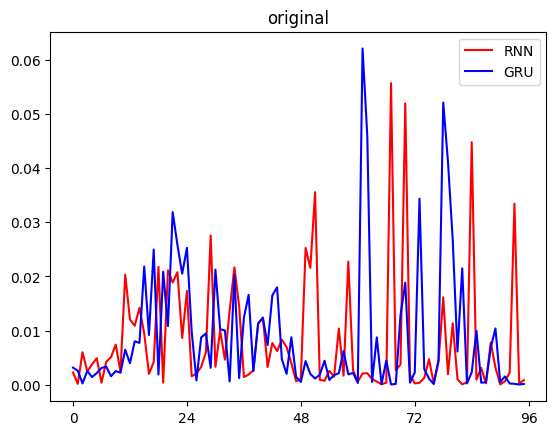

In [107]:
import matplotlib.pyplot as plt
plt.title("original")
plt.plot(RNN_loss,'r',label = "RNN")
plt.plot(GRU_loss,'b',label = "GRU")
plt.xticks(np.arange(0,96+1,24))
# plt.yticks(np.arange(0,0.2,0.05))
# plt.title("Loss_4")
# plt.savefig(f"{base_path}/result/loss_4")
plt.legend()
plt.show()

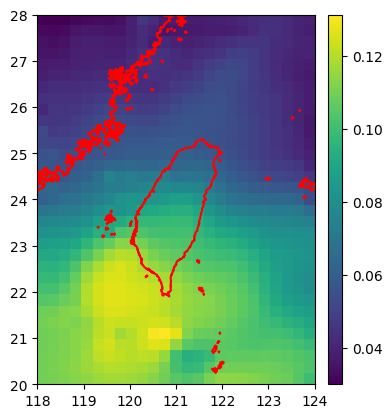

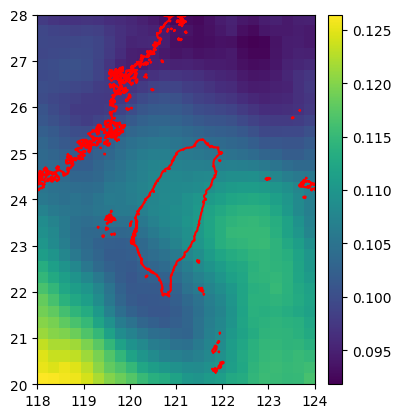

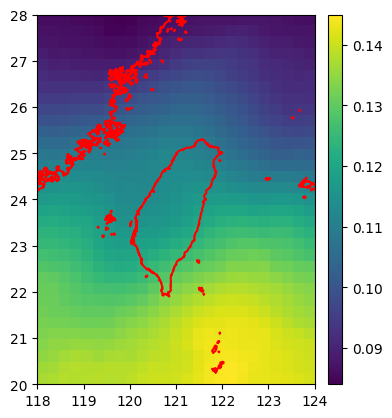

In [134]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
n = np.random.randint(96)

asian_map = np.load("asian_map.npy")
fig = plt.figure() # 創建圖形物件

ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cmap = "jet"

cax.cla()
tx, ty = [118,20]
ax.set_xlim(118,124)
ax.set_ylim(20,28)

im = ax.imshow(val_ori[n], origin = "lower", zorder = 1, extent = (tx,tx+6,ty,ty+8))  #-------------------Here to change the colorbar range
ax.plot(asian_map[:,0], asian_map[:,1], c = "r", zorder = 2)
fig.colorbar(im, cax=cax)




fig = plt.figure() # 創建圖形物件

ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cmap = "jet"

cax.cla()
tx, ty = [118,20]
ax.set_xlim(118,124)
ax.set_ylim(20,28)

im = ax.imshow(pred_RNN[n], origin = "lower", zorder = 1, extent = (tx,tx+6,ty,ty+8))  #-------------------Here to change the colorbar range
ax.plot(asian_map[:,0], asian_map[:,1], c = "r", zorder = 2)
fig.colorbar(im, cax=cax)




fig = plt.figure() # 創建圖形物件

ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cmap = "jet"

cax.cla()
tx, ty = [118,20]
ax.set_xlim(118,124)
ax.set_ylim(20,28)

im = ax.imshow(pred_GRU[n], origin = "lower", zorder = 1, extent = (tx,tx+6,ty,ty+8))  #-------------------Here to change the colorbar range
ax.plot(asian_map[:,0], asian_map[:,1], c = "r", zorder = 2)
fig.colorbar(im, cax=cax)